# Week 6_Day3: Training Loop in CNN

### PART I — Preparing Data in Right Form (Dataset + Dataloader)

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# 1) Transform: turn image into tensor
transform = transforms.ToTensor()

# 2) Load full training set
full_train = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# 3) Split into train/val
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

# 4) Test set (separate)
test_ds = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# 5) DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

### PART II — Setup: Model, Loss, Optimizer, Device

**Device Selection**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Defining and Using CNN Model**

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # conv layer1
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=16,
            kernel_size=3, 
            padding=1
        )

        # conv layer2
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            padding=1
        )

        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fc layers
        self.fc1 = nn.Linear(32*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [6]:
model = SimpleCNN().to(device)

**Loss Function & Optimizer**

In [9]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### PART III — The Training Loop

**Training One Epoch**

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # IMPORTANT: enables training behavior (dropout/batchnorm)

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

**Validation One Epoch**

In [11]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # IMPORTANT: disables training behavior (dropout etc.)

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

### PART IV — Run Training for Multiple Epochs + Track Curves

In [12]:
import matplotlib.pyplot as plt

EPOCHS = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}")

Epoch 1/10 | Train Loss: 1.6133, Train Acc: 0.4198 | Val Loss: 1.3567, Val Acc: 0.5038
Epoch 2/10 | Train Loss: 1.2731, Train Acc: 0.5470 | Val Loss: 1.1994, Val Acc: 0.5718
Epoch 3/10 | Train Loss: 1.1391, Train Acc: 0.5954 | Val Loss: 1.1182, Val Acc: 0.6048
Epoch 4/10 | Train Loss: 1.0437, Train Acc: 0.6318 | Val Loss: 1.0596, Val Acc: 0.6280
Epoch 5/10 | Train Loss: 0.9732, Train Acc: 0.6595 | Val Loss: 1.0106, Val Acc: 0.6434
Epoch 6/10 | Train Loss: 0.9185, Train Acc: 0.6775 | Val Loss: 0.9642, Val Acc: 0.6562
Epoch 7/10 | Train Loss: 0.8680, Train Acc: 0.6942 | Val Loss: 0.9454, Val Acc: 0.6670
Epoch 8/10 | Train Loss: 0.8284, Train Acc: 0.7075 | Val Loss: 0.9448, Val Acc: 0.6686
Epoch 9/10 | Train Loss: 0.7868, Train Acc: 0.7213 | Val Loss: 0.9860, Val Acc: 0.6624
Epoch 10/10 | Train Loss: 0.7532, Train Acc: 0.7349 | Val Loss: 0.9370, Val Acc: 0.6808


### PART V — Plot Training Curves

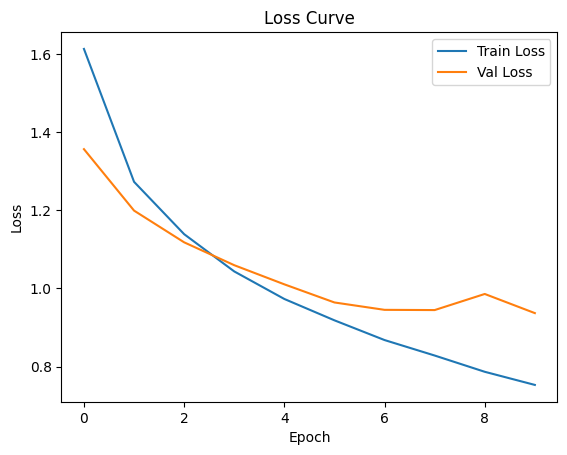

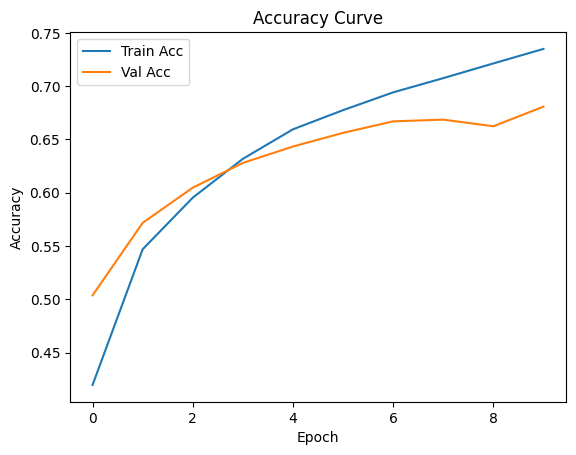

In [13]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()